# Morphology of noiseless images with statmorph

Statmorph is an open-source Python code for calculating non-parametric galaxy morphology. This is an alternative package, which calculates morphology for simulated images without any image noise.

[Docs](https://statmorph.readthedocs.io/en/latest/) | [GitHub](https://github.com/vrodgom/statmorph) | [Rodriguez-Gomez et al., 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.483.4140R)

## Test data

Simulated galaxy snapshot from the [Illustris](https://www.illustris-project.org) public dataset

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
%matplotlib inline

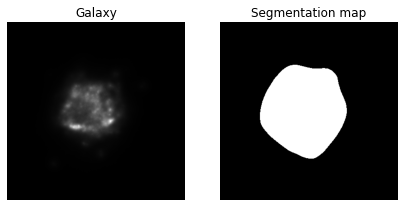

In [109]:
file   = fits.open("test_file.fits")
img    = file[0].data
segmap = file[1].data
file.close()

fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(img, cmap="gray"); axs[1].imshow(segmap, cmap="gray"); 
axs[0].set_title("Galaxy"); axs[1].set_title("Segmentation map")
for ax in axs: ax.axis('off')

## Statmorph

Class **SourceMorphology**: main class where all morphology parameters are calculated.
- Added argument `noiselss`: `True` or `False`. Set `True` for noise-free images.
- Line 428: if noiseless image, set the weightmap to ones 
- Line 481: no flag if noiseless image is not background-subtracted

**_weightmap_stamp**:
- Set to ones, because there is no noise or artifacts.

**smoothness**
- Set `_sky_smoothness` to 0 for noise-free images
**asymmetry**:
- Set `_sky_asymmetry` to 0 for noise-free images
**shape asymmetry**
- Use input segmap instead of shape asymmetry segmap

**sky_mean**, **sky_median**, **_slice_skybox**
- Set to 0 if noiseless

Make `_mask_stamp_no_bg` equal to `_mask_stamp`. Same with 

### SourceMorphology algorithm

1. Set input parameters: 
    - image, segmap, label, mask, psf, weightmap, gain, verbose
    - _cutout_extent, _min_cutout_size: image cutout
    - _n_sigma_outlier: gets rid of artifacts
    - annulus_width, eta, petro_fraction_gini, petro_extent_cas, petro_fraction_cas, boxcar_size_mid, niter_bh_mid, sigma_mid, petro_extent_flux, boxcar_size_shape_asym, sersic_maxiter, segmap_overlap_ratio, : morphology parameters
    - skybox_size: for estimating background
    
2. Check if segmap makes sense and dimensions of mask, segmap, weightmap, and image are correct
3. Normalize PSF if given
4. Set all flags to 0 (might change if to 1 if something goes wrong)
5. Create cutout stamps and check the flux is positive
    - Try to make a square image slice stamp: `_slice_stamp` lazy property
    - Corresponding `_mask_stamp` and `_mask_stamp_no_bg` (where background is masked as well)
        - Mask everything but background and current source for `_mask_stamp`, and everything but source for the `no_bg`, using segmap labels.
        - <font color="blue">Will not change this in case simulated galaxies have mergers etc; will still define segmaps with  SB threshold</font>
    - Calculate flux in the stamp, `_cutout_stamp_maskzeroed` and `_cutout_stamp_maskzeroed_no_bg` and check if the flux if the total flux, with background excluded, of the object is 0
    
6. Compute the centroid of the source
    - Defines `xmin_stamp` and `ymin_stamp`, coord of the corner of the cutout
    - Computes `_centroid` (hence `xc_centroid` and `yc_centroid`) using first order of the masked, bg-free image cutout
    - Also compute the location of the brightest pixel, `_x_maxval_stamp` and `_y_maxval_stamp`
    
    
7. Compute morphology with `_calculate_morphology` method

8. Check if the image is background-subtracted
    - <font color="blue">Flag if it is not, unless the image is noiseless</font>
    
9. Compare Gini and MID segmaps; flag if they are very different.


### Calculating morphology algorithm

Iterate through different lazy properties in `_quantity_names` and set them in order.

* 'xc_centroid', 'yc_centroid': already calculated in **SourceMorphology** init
* 'ellipticity_centroid', 'elongation_centroid', 'orientation_centroid'
    - Calculate `_covariance_centroid` using xc and yc centroids: covariance of a Gaussian with the same 2nd moment as the source
    - Calculate eigenvalues of the cov. matrix using `_eigvals_generic`, set `_eigvals_centroid`
    - Use these to get ellipticity, elongation and orientation
* 'xc_asymmetry', 'yc_asymmetry': center that minimizes the CAS asymmetry
    - Calculate `_asymmetry_center`: minimize asymmetry calculated with `_asymmetry_function` at different proposed centers. Initial guess is the image center. Background is not masked in this case.
    - **Calculate Petrosian radius**, $R_{pet}$ - `_rpetro_circ_centroid`
        - At the Petrosian radius $r$, the ratio between mean flux in the annulus and mean flux within $r$ is equal to $\eta$.
        - Find a good guess region $r_{min} < R_{pet} < r_{max}$ by calculating the `_petrosian_func_circ` at 100 different radii, then $r_{min}$ and $r_{max}$ are over/undershoot radii.
        - Use `brentq` minimizer to find the root of `_petrosian_func_circ` between $r_{min}$ and $r_{max}$.
    - Rotate the image by 180 degrees around the center & apply symmetric mask
    - Calculate image and difference flux within circular aperture of size `petro_extent_flux` $\times R_{pet}$
    - Calculate and subtract `_sky_asymmetry` - <font color="blue">Set this to 0 for noiseless images</font>
    - **Therefore, at this point '_asymmetry_center', '_sky_asymmetry', '_rpetro_circ_centroid', '_slice_skybox' are calculated**. <font color="blue">For noiseless images, sky asymmetry is 0 and slice skybox is skipped.</font>
* 'ellipticity_asymmetry', 'elongation_asymmetry', 'orientation_asymmetry'
    - Same as centroid ones, but calculated with the asymmetry center from before
* 'flux_circ', 'flux_ellip'
    - Flux within $NR_{pet}$ around asymmetry center with asym. ellipticity
* 'rpetro_circ', 'rpetro_ellip'
    - Petrosian radius computed using asymmetry center instead of centroid
* 'rmax_circ', 'rmax_ellip'
    - Size of the circle/ellipse that contains all of the segmap, starting at the asymmetry center
* 'rhalf_circ', 'rhalf_ellip'
    - Circle/ellipse that contains 50% of light, where total is at `rmax`, computed with `_radius_at_fraction_of_total_circ`
    - Computed similar to the Petrosian radius
* 'r20', 'r50', 'r80'
    - Radius containing 20/50/80% of light, where total is at $NR_{pet}$, computed with `_radius_at_fraction_of_total_cas`. Used lated in CAS.
* 'gini'
    - Create a new Gini segmap `_segmap_gini` based on elliptical $R_{pet}$
    - Smooth the image, use *mean flux at the Petrosian radius* as threshold for segmap
    - Use ndi's 8-connected algorithm to grow the segmentation map   (`generate_binary_structure(2,2)`)
    - If the Gini segmap is empty, completely full, or there are more than 1 elements on it, raise a flag.
    - <font color="blue">I don't think there should be issues here, because $R_{pet}$ is still well-defined even when there is no noise.</font>
    - Sorts pixels at finds Gini as described in Lotz 2004
    
* 'm20', 'gini_m20_bulge', 'gini_m20_merger'
    - Calculate the rest of parameters as in Lotz 2004 and Rodriguez-Gomez 2019, only within the Gini segmap region.
    
* 'sn_per_pixel'
    - <font color="blue">Return `inf` if noiseless</font>
    - Find the `_weightmap_stamp`
        - If not user-supplied, this is given by $\sqrt{\textrm{Img} / \textrm{Gain} + \sigma^2}$
        - **By the way, user-supplied weightmap should include sky and poisson noise**
        - <font color="blue">Set this to just ones for noiseless images</font>
    - Calculate SNR per pixel within the Gini segmap using the `_weightmap_stamp`.
* 'concentration'
    - use 'r20' and 'r80' from before to calculate C as in Lotz 2004
* 'asymmetry'
    - use `_asymmetry_center` from before to calculate CAS asymmetry
* 'smoothness'
    - Calculate smoothness as in Lotz 2004 (10x less than in Conselice 2003)
    - Exlcude the central region from calculation and smooth the image
    - Calculate the difference between original and smoothed images
    - Calculate and subtract `_sky_smoothness`
        - Smoothness of the `_slice_skybox`. <font color="blue">Set this to 0 for noiseless images</font>
* 'multimode'
    - Calculate as in Freeman 2013 and Peth 2016. The algorithm is complex so I don't give it in these notes.
    - Involved functions: `_multimode_ratio`, `_cutout_mid`, `_multimode_function`, `_segmap_mid`, `_segmap_mid_function`, `_segmap_mid_main_clump`, `_sorted_pixelvals_mid`
        - <font color="blue">`_cutout_mid` uses `_cutout_stamp_maskzeroed_no_bg_nonnegative` which is just `_cutout_stamp_maskzeroed` in noiseless images</font>
        - <font color="blue">`_segmap_mid` uses `_sorted_pixelvals_stamp_no_bg_nonnegative` and `_cutout_stamp_maskzeroed_no_bg_nonnegative`</font>
        - <font color="blue">`_sorted_pixelvals_mid` uses `_mask_stamp_no_bg`</font>
* 'intensity', 'deviation'
    - Described in Peth et al., 2016
    - Calculates the watershed segmap with `_watershed_mid` and smoothed with `_cutout_mid_smooth`
* 'outer_asymmetry'
    - Similar to asymmetry, but only within 'rmax' and 'rhalf' (elliptical)
* 'shape_asymmetry'
    - Calculates the shape asymmetry segmap with `_segmap_shape_asym`
        - Similar to Pawlik 2016: look within $NR_{pet}$ and $2NR_{pet}$
        - If the annulus doesn't fit in the image, use the skybox for background instead.
        - <font color="blue">At this point the code expects `_slice_skybox` to be defined</font>
    - Estimate background using a mode estimator from photutils
    - Sigma-clip the image to get the background median, and then calculate its mode 
    - Set the threshold as the background mode + std
    - <font color="blue">For noiseless images, just use the input segmentation map instead.</font>
    - Then calculates asymmetry using the segmap within 'rmax'
 
* 'sersic_amplitude', 'sersic_rhalf', 'sersic_n', 'sersic_xc', 'sersic_yc', 'sersic_ellip', 'sersic_theta'
    - Calculate all values in `_sersic_model`.
    - In the fitting, expects the sky background to be already included in the weightmap (which it is not).
    - Use models.Sersic2D to find the best fit parameters from astropy.modeling.models.Sersic2D
* 'sky_mean', 'sky_median', 'sky_sigma':
    - Set to 0 if noiseless
* 'xmin_stamp', 'ymin_stamp', 'xmax_stamp' 'ymax_stamp', 'nx_stamp', 'ny_stamp':
    - Defined above

## <font color="red">**To do:**</font>

* Check that Sersic fitting works

In [110]:
%reload_ext autoreload
%autoreload 2

from statmorph.statmorph import source_morphology
from statmorph.utils.image_diagnostics import make_figure

In [111]:
test = source_morphology(img, segmap, noiseless=True)
# test = source_morphology(img, segmap, noiseless=False, gain=1)

True


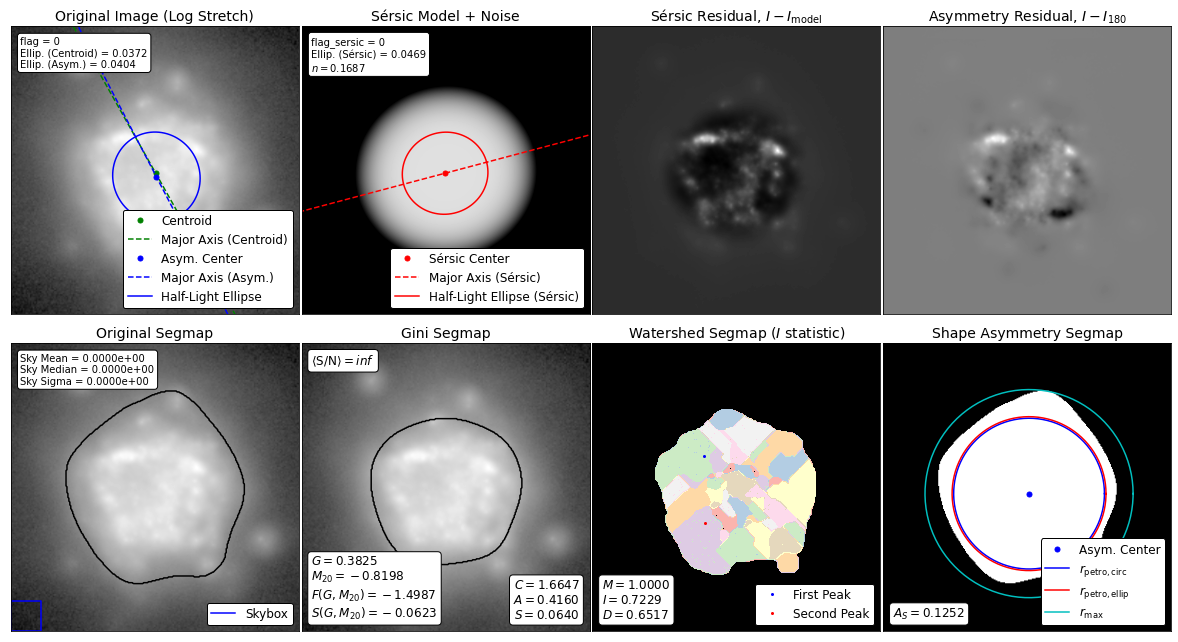

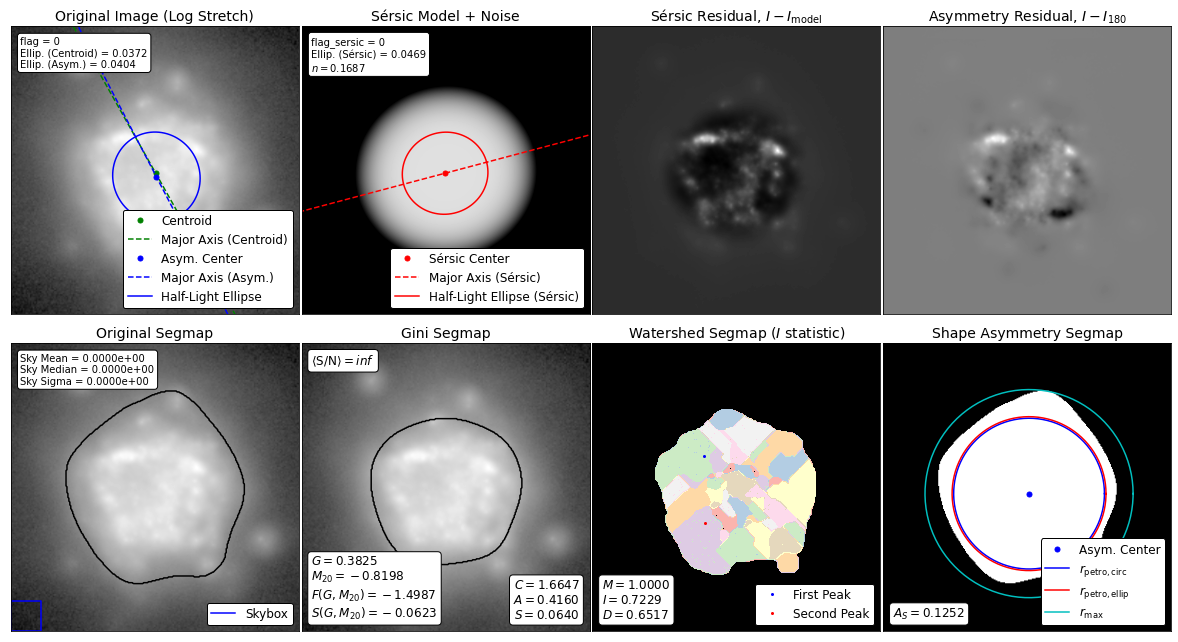

In [112]:
make_figure(test[0])